In [65]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ta



In [2]:
tickers = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
print(tickers.columns)
symbols = tickers.Ticker.to_list()
print(symbols[1:10])
df = yf.download(symbols, start = '2022-10-01')['Adj Close']
print(df.head())

Index(['Company', 'Ticker', 'GICS Sector', 'GICS Sub-Industry'], dtype='object')
['ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI']
[*********************100%***********************]  101 of 101 completed
                  AAPL        ABNB        ADBE         ADI         ADP   
Date                                                                     
2022-10-03  141.052078  105.000000  285.239990  141.121704  224.695694  \
2022-10-04  144.666229  110.809998  294.970001  146.683731  228.923553   
2022-10-05  144.963287  111.760002  297.380005  147.694977  231.274521   
2022-10-06  144.002808  111.580002  298.410004  146.800400  227.249817   
2022-10-07  138.715225  108.540001  288.769989  140.917465  219.732559   

                  ADSK        AEP       AMAT        AMD        AMGN  ...   
Date                                                                 ...   
2022-10-03  192.460007  82.226234  85.106102  66.110001  217.933365  ...  \
2022-10-04  199.990005  84.49

In [4]:
df.dropna(axis = 1, inplace = True)
df = (df.pct_change()+1)[1:].resample("M").prod() # proste stopy zwrotu/ jeśli ln to sumujemy (.prod() - mnożymy)
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,1.076448,1.018191,1.116604,0.982705,1.040689,1.113478,0.996486,1.023652,0.908486,1.173190,...,0.870931,1.045166,1.012955,1.048578,1.048986,1.125501,1.087866,1.010178,0.993439,0.903759
2022-11-30,0.966973,0.955383,1.082983,1.205371,1.092842,0.942370,1.111336,1.244386,1.292541,1.066664,...,0.979339,0.892049,1.123452,1.004813,1.014103,1.150369,0.876923,1.077525,1.078483,0.865996
2022-12-31,0.877727,0.837086,0.975647,0.958410,0.908675,0.925328,0.980888,0.888504,0.834342,0.917039,...,0.859801,0.985240,0.915549,0.961932,0.912705,0.900241,0.831579,0.996605,1.005288,0.838516
2023-01-31,1.110521,1.299532,1.100467,1.045357,0.945365,1.151389,0.989574,1.144896,1.160259,0.961011,...,1.130939,1.087391,1.080214,1.030439,1.118845,0.986617,1.563291,1.084265,0.980887,1.109562
2023-02-28,1.023183,1.109531,0.874737,1.074963,0.973473,0.923452,0.944927,1.044237,1.045642,0.925923,...,1.103747,0.967500,0.967496,0.941251,0.898453,0.976674,1.053981,1.022268,0.938927,1.056298


In [5]:
def get_rtn(df, n):
  return df.rolling(n).apply(np.prod)

In [7]:
def get_top(date, df):
  r12 = get_rtn(df, 12)
  r6 = get_rtn(df, 6)
  r3 = get_rtn(df, 3)
  top50 = r12.loc[date].nlargest(50).index
  top30 = r6.loc[date, top50].nlargest(30).index
  top_10 = r3.loc[date, top30].nlargest(10).index
  return top_10

get_top('2023-02-28', df)

Index(['BKNG', 'ABNB', 'ANSS', 'CDNS', 'AVGO', 'ADI', 'CDW', 'AMAT', 'BKR',
       'CPRT'],
      dtype='object')

In [8]:
def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_top(date,df)][1:2]) # [1:2] - wiersze; jesli chcemy kolenne to tu zmieniamy

[1.096084879990868, 0.9103647304316425, 1.0744086354161035, 1.0272502020152687, 1.0438075307910268, 0.9502062592499578, 1.0620889175388666, 1.030791935121105, 1.0627335738972026, 0.9724185274815215, 0.9765852449098968, 0.9638358349363967, 1.12900161564525, 1.0383775226970817, 1.0122444631692675, 1.0466310317311391, 1.0368310688136244, 0.939283775368423, 1.0584571394415447]


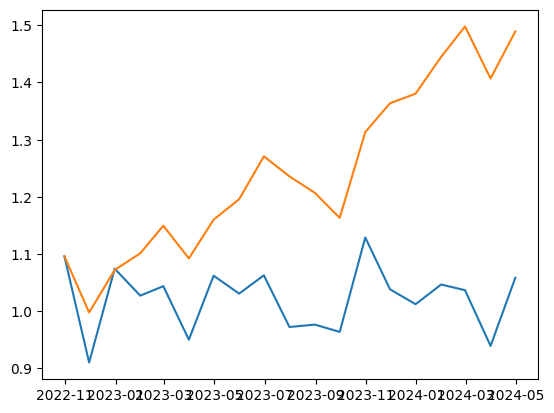

In [11]:
dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

In [25]:
# Losowe 10 spółek spośród 50 z największym zwrotem

def get_random_50(date, df, random_state=None):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top_10 = r3.loc[date, top50].sample(n=10, random_state=random_state).index
    return top_10

get_random_50('2023-02-28', df)

Index(['CSX', 'CSGP', 'FTNT', 'AMZN', 'CTAS', 'DXCM', 'AEP', 'CTSH', 'COST',
       'GOOGL'],
      dtype='object')

In [26]:
def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_50(date,df)][1:2]) 

[1.0905558888996667, 0.9158701691894361, 1.0605906889629375, 0.9418072506780885, 1.0884218926937834, 0.9729532863272038, 1.034802625248407, 1.0420435121856746, 1.0303205158590134, 0.9735275968440067, 0.9867859508076118, 0.963285202065352, 1.0981995813171392, 1.0558417883529199, 1.0747077407763066, 1.0319552809153647, 1.0174070439562848, 0.9647491476009871, 1.0741443598675775]


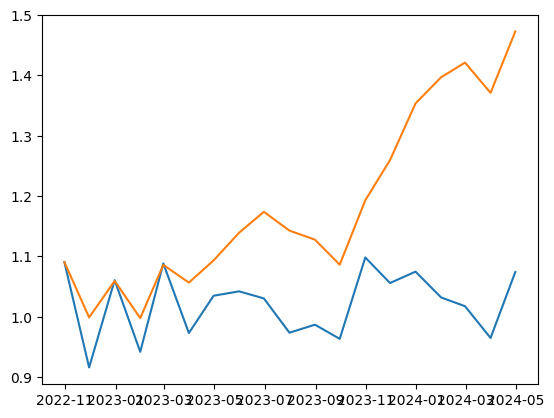

In [27]:
dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

In [29]:
df

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,1.076448,1.018191,1.116604,0.982705,1.040689,1.113478,0.996486,1.023652,0.908486,1.173190,...,0.870931,1.045166,1.012955,1.048578,1.048986,1.125501,1.087866,1.010178,0.993439,0.903759
2022-11-30,0.966973,0.955383,1.082983,1.205371,1.092842,0.942370,1.111336,1.244386,1.292541,1.066664,...,0.979339,0.892049,1.123452,1.004813,1.014103,1.150369,0.876923,1.077525,1.078483,0.865996
2022-12-31,0.877727,0.837086,0.975647,0.958410,0.908675,0.925328,0.980888,0.888504,0.834342,0.917039,...,0.859801,0.985240,0.915549,0.961932,0.912705,0.900241,0.831579,0.996605,1.005288,0.838516
2023-01-31,1.110521,1.299532,1.100467,1.045357,0.945365,1.151389,0.989574,1.144896,1.160259,0.961011,...,1.130939,1.087391,1.080214,1.030439,1.118845,0.986617,1.563291,1.084265,0.980887,1.109562
2023-02-28,1.023183,1.109531,0.874737,1.074963,0.973473,0.923452,0.944927,1.044237,1.045642,0.925923,...,1.103747,0.967500,0.967496,0.941251,0.898453,0.976674,1.053981,1.022268,0.938927,1.056298
2023-03-31,1.118649,1.009085,1.189597,1.074944,1.018519,1.047662,1.034330,1.057512,1.247264,1.043555,...,1.088456,1.089000,1.084923,1.123378,1.085363,0.973262,0.966709,1.113603,1.052832,0.890812
2023-04-30,1.028987,0.961977,0.979734,0.912078,0.988187,0.935771,1.015716,0.920215,0.911846,0.991686,...,1.056313,1.041827,0.898876,1.011727,1.081442,1.019375,0.901324,0.901230,1.036625,0.771206
2023-05-31,1.046058,0.917272,1.106553,0.987825,0.949955,1.023615,0.907548,1.182372,1.322703,0.929056,...,1.089214,1.108134,1.047959,1.128793,0.949638,0.874664,0.828802,1.138874,0.933915,1.503663
2023-06-30,1.094330,1.167532,1.170420,1.101599,1.057785,1.026180,1.012993,1.084321,0.963624,1.006209,...,1.101884,1.068467,1.035312,1.033200,1.087585,0.938097,1.111702,1.065569,0.960122,1.079864


[1.1051095830396354, 0.9469497338972847, 1.0759506718093148, 1.0032109979987793, 1.074598417201252, 0.9631568995618025, 1.033693865398995, 1.0548178415071872, 1.0793457631274843, 0.9545301178201873, 0.9445809084955169, 0.9435059877713347, 1.1974841079257428, 1.063397604565803, 1.0525645164808373, 1.0224901153976487, 1.0570606264423108, 0.9436768698761403, 1.0462330226006045]


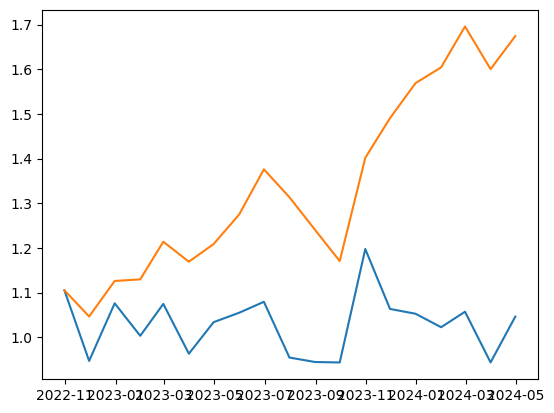

In [28]:
# Losowe 10 spółek spośród 30 z największym zwrotem

def get_random_30(date, df, random_state=None):
    r12 = get_rtn(df, 12)
    r6 = get_rtn(df, 6)
    r3 = get_rtn(df, 3)
    top50 = r12.loc[date].nlargest(50).index
    top30 = r6.loc[date, top50].nlargest(30).index
    top_10 = r3.loc[date, top30].sample(n=10, random_state=random_state).index
    return top_10

def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_30(date,df)][1:2]) 


dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

[1.051931415590169, 0.9365761664441268, 1.1112530648704573, 0.996111113522201, 1.1024589559066504, 0.9386549776912891, 1.106773327890266, 1.0638879765810196, 1.0582518953310611, 0.938595026634023, 0.9556584658799647, 0.9752320702145599, 1.0366449577737842, 1.0655543370415979, 1.0040374976001216, 1.1050462225955022, 1.04857238263499, 0.9595505459314057, 1.0534867507274055]


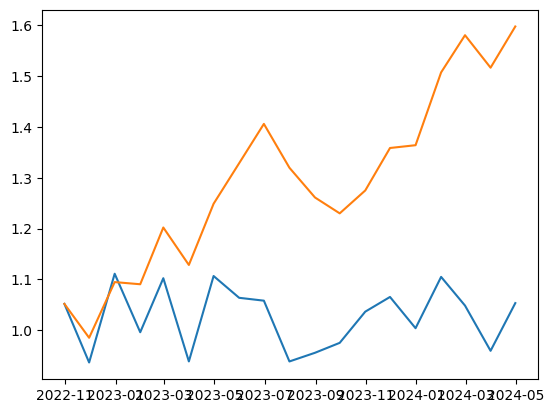

In [30]:
def get_random_10(date, df, random_state=None):
    top_10 = df.loc[date].sample(n=10, random_state=random_state).index
    return top_10

def portfolio_res(date, df):
  return np.mean(df.loc[date:,get_random_10(date,df)][1:2]) 


dates = df.index[:-1]
returns = []
for d in dates:
  returns.append(portfolio_res(d, df))

print(returns)

plt.plot(dates, returns)
cum_returns = pd.Series(returns).cumprod()
plt.plot(dates, cum_returns)

## Wskaźniki AT

In [33]:
from ta import add_all_ta_features
from ta.utils import dropna

In [ ]:
def portfolio_res(date, df):
  return np.proc()(df.loc[date:,get_random_10(date,df)][1:2]) 


In [55]:
start_test = "2021-01-01"
end_test = "2023-12-31"
start_train = "2024-01-01"
end_train = "2024-12-31"

tickers = ['TSLA', 'MSFT', 'AMZN']

for ticker in tickers:
    data_train = yf.download(ticker, start=start_train, end=end_train)
    data_train['Name'] = ticker  # Dodawanie kolumny z symbolem
    data_train.to_csv(f'{ticker}_train.csv')  

for ticker in tickers:
    data_test = yf.download(ticker, start=start_test, end=end_test)
    data_test['Name'] = ticker  # Dodawanie kolumny z symbolem
    data_test.to_csv(f'{ticker}_test.csv') 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
def merge_csv_files(pattern, output_filename):
    all_filenames = glob.glob(pattern)
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(output_filename, index=False, encoding='utf-8-sig')

# Łączenie plików 
merge_csv_files('*_train.csv', 'price_data_train.csv')
merge_csv_files('*_test.csv', 'price_data_test.csv')

In [97]:
price_data = pd.read_csv('price_data_train.csv')
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
283,2024-05-13,170.000000,175.399994,169.000000,171.889999,171.889999,67018900,TSLA
284,2024-05-14,174.500000,179.490005,174.070007,177.550003,177.550003,86407400,TSLA
285,2024-05-15,179.899994,180.000000,173.110001,173.990005,173.990005,79663000,TSLA
286,2024-05-16,174.100006,175.789993,171.429993,174.839996,174.839996,59812200,TSLA
287,2024-05-17,173.550003,179.630005,172.750000,177.460007,177.460007,76627600,TSLA


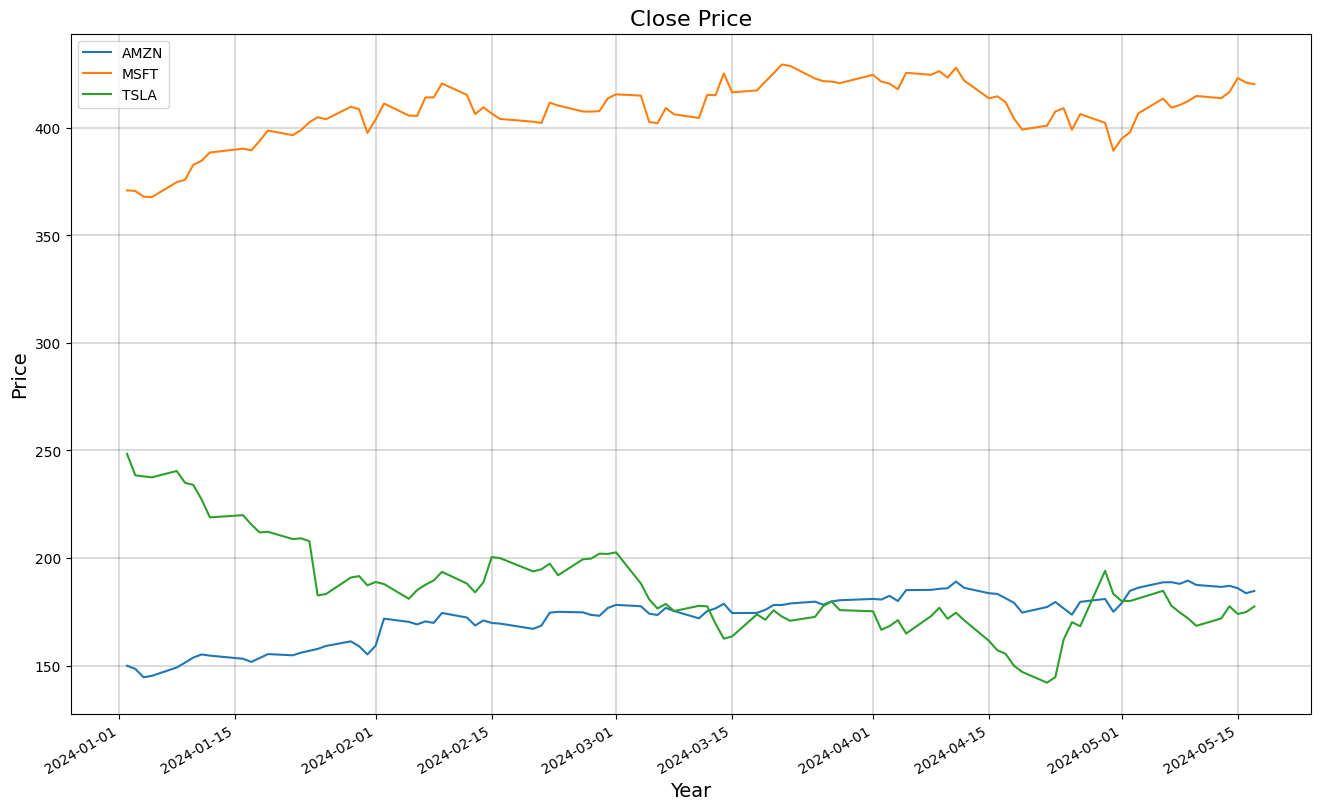

In [98]:
price_data['Date'] = pd.to_datetime(price_data['Date'])

# Ustawienie kolumny Date jako indeks
price_data.set_index('Date', inplace=True)

plt.figure(figsize=(16, 10))
for name, group in price_data.groupby('Name'):
    group['Close'].plot(label=name)

plt.legend(loc='upper left')
plt.title("Close Price", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-', linewidth=0.2)
plt.show()

RSI, Stochastic oscilator, EMA, MACD, ADX

In [99]:
result_data = pd.DataFrame()

for ticker in tickers:
    df_ticker = price_data[price_data['Name'] == ticker].copy()

    # Obliczanie AT
    df_ticker[f'{ticker}_RSI'] = ta.momentum.RSIIndicator(close=df_ticker['Close']).rsi()
    df_ticker[f'{ticker}_Stochastic'] = ta.momentum.StochasticOscillator(high=df_ticker['High'], low=df_ticker['Low'], close=df_ticker['Close']).stoch()
    df_ticker[f'{ticker}_EMA'] = ta.trend.EMAIndicator(close=df_ticker['Close'], window=20).ema_indicator()
    macd = ta.trend.MACD(close=df_ticker['Close'])
    df_ticker[f'{ticker}_MACD'] = macd.macd()
    df_ticker[f'{ticker}_MACD_Signal'] = macd.macd_signal()
    df_ticker[f'{ticker}_MACD_Diff'] = macd.macd_diff()
    df_ticker[f'{ticker}_ADX'] = ta.trend.ADXIndicator(high=df_ticker['High'], low=df_ticker['Low'], close=df_ticker['Close'], window=14).adx()

    # Łączenie wyników
    result_data = pd.concat([result_data, df_ticker], ignore_index=True)
    
# Zresetowanie indeksu w `price_data`, jeśli jest to wymagane
price_data = price_data.reset_index()

# Aktualizacja price_data na podstawie wyników
price_data = pd.merge(price_data, result_data.drop(columns=['High', 'Low', 'Close']), left_index=True, right_index=True)
# Ustawienie `Date` z powrotem jako indeksu
#price_data = price_data.set_index('Date')

# Zapis wyników do pliku CSV
price_data.to_csv('price_data_with_indicators.csv', encoding='utf-8-sig')


In [100]:
price_data

,Date,Open_x,High,Low,Close,Adj Close_x,Volume_x,Name_x,Open_y,Adj Close_y,...,MSFT_MACD_Signal,MSFT_MACD_Diff,MSFT_ADX,AMZN_RSI,AMZN_Stochastic,AMZN_EMA,AMZN_MACD,AMZN_MACD_Signal,AMZN_MACD_Diff,AMZN_ADX
0,2024-01-02,151.539993,152.380005,148.389999,149.929993,149.929993,47339400,AMZN,250.080002,248.419998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-03,149.199997,151.050003,148.330002,148.470001,148.470001,49425500,AMZN,244.979996,238.449997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-04,145.589996,147.380005,144.050003,144.570007,144.570007,56039800,AMZN,239.250000,237.929993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-05,144.690002,146.589996,144.529999,145.240005,145.240005,45124800,AMZN,236.860001,237.490005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100,AMZN,236.139999,240.449997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-05-13,170.000000,175.399994,169.000000,171.889999,171.889999,67018900,TSLA,188.000000,186.570007,...,NaN,NaN,NaN,56.305269,79.787267,183.846077,2.293207,1.642716,0.650491,14.849142
284,2024-05-14,174.500000,179.490005,174.070007,177.550003,177.550003,86407400,TSLA,183.820007,187.070007,...,NaN,NaN,NaN,57.037828,81.757323,184.153118,2.264476,1.767068,0.497409,13.918952
285,2024-05-15,179.899994,180.000000,173.110001,173.990005,173.990005,79663000,TSLA,185.970001,185.990005,...,NaN,NaN,NaN,54.896907,66.213056,184.328059,2.130007,1.839656,0.290351,13.238060
286,2024-05-16,174.100006,175.789993,171.429993,174.839996,174.839996,59812200,TSLA,185.600006,183.630005,...,NaN,NaN,NaN,50.441399,52.248550,184.261578,1.812118,1.834148,-0.022030,12.438086
